# Template Notebook for testing an Island Model GA with artists on an island
Notebook Version: 0.2 (01/03/2024)

In [12]:
from evolutionary.plotting import plot_fitness_statistics
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation
from datetime import datetime
import torch
import os

In [13]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To remove warning of libraries using tokenizers

def save_images_post_evaluation(g, a):
    now = datetime.now()
    time_str = now.strftime("%H%M%S") # append a timestring to avoid overlapping of different GAs when saving images
    save_images_from_generation(a.population, g, time_str)
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([226,  70,  39,  ...,   0,   0,   0], dtype=torch.uint8)


In [14]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import \
    UniformGaussianMutatorArguments, PooledUniformGaussianMutator, PooledArithmeticCrossover, PooledUniformCrossover
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange
from evolutionary.selectors import TournamentSelector, RouletteWheelSelector, RankSelector
from evolutionary.algorithms.island_model import IslandModel
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary_imaging.evaluators import AestheticsImageEvaluator

population_size = 4
num_generations = 100
batch_size = 1
elitism = None
inference_steps = 3
artworks_list = [
    "The Starry Night by Vincent van Gogh",
    "The Last Supper by Leonardo da Vinci",
    "Mona Lisa by Leonardo da Vinci",
    "Sistine Chapel Ceiling by Michelangelo",
    "The School of Athens by Raphael",
    "The Night Watch by Rembrandt van Rijn",
    "Girl with a Pearl Earring by Johannes Vermeer",
    "The Swing by Jean-Honoré Fragonard",
    "Liberty Leading the People by Eugène Delacroix",
    "Impression, Sunrise by Claude Monet",
    "A Sunday Afternoon on the Island of La Grande Jatte by Georges Seurat",
    "The Scream by Edvard Munch",
    "The Kiss by Gustav Klimt",
    "Les Demoiselles d'Avignon by Pablo Picasso",
    "Fountain by Marcel Duchamp",
    "Jacob’s Ladder by Helen Frankenthaler",
    "Untitled by Kazuo Shiraga",
    "Masks Confronting Death by James Ensor",
    "Wall Hanging by Anni Albers",
    "Painting by Francis Bacon",
    "Ladybug by Joan Mitchell",
    "Equal by Richard Serra",
    "Woman I by Willem de Kooning",
    "Marilyn Diptych by Andy Warhol",
    "Whaam! by Roy Lichtenstein",
    "One And Three Chairs by Joseph Kosuth",
    "Interior Scroll by Carolee Schneemann",
    "Untitled Film Still #21 by Cindy Sherman",
    "Gordon’s Makes Us Drunk by Gilbert & George",
    "Do Women Have To Be Naked To Get Into The Met. Museum? by Guerilla Girls",
    "The Physical Impossibility Of Death In The Mind Of Someone Living by Damien Hirst",
    "Number 1, 1950 (Lavender Mist) by Jackson Pollock",
    "Campbell’s Soup Cans by Andy Warhol",
    "Sky Cathedral by Louise Nevelson",
    "Elegy to the Spanish Republic No. 110 by Robert Motherwell",
    "The Bay by Helen Frankenthaler",
    "Vir Heroicus Sublimis by Barnett Newman",
    "Woman III by Willem de Kooning",
    "No. 5, 1948 by Jackson Pollock",
    "Convergence by Jackson Pollock",
    "The Marilyn Diptych by Andy Warhol",
    "I and the Village by Marc Chagall",
    "The Persistence of Memory by Salvador Dalí",
    "Guernica by Pablo Picasso",
    "Broadway Boogie Woogie by Piet Mondrian",
    "Nighthawks by Edward Hopper",
    "American Gothic by Grant Wood",
    "Christina’s World by Andrew Wyeth",
    "The Two Fridas by Frida Kahlo",
    "The Great Wave off Kanagawa by Katsushika Hokusai"
]

# Initialize GA instances
embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
# Create the necessary components for the genetic algorithm
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=inference_steps)
evaluator = AestheticsImageEvaluator() 
crossover = PooledArithmeticCrossover(crossover_rate=0.6, crossover_rate_pooled=0.6)
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=1.5, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=0.2, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = RankSelector()

ga_instances = []

init_crossover = PooledArithmeticCrossover(crossover_rate=0.8, crossover_rate_pooled=0.8)
for work in artworks_list:
    artist_arg = creator.arguments_from_prompt(work) 

    init_args = [init_crossover.crossover(artist_arg,  # Combine the work with a random image, weighted towards the work
                                          PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range())) 
                 for _ in range(population_size)]
    
    # Create and run the genetic algorithm
    ga_instances.append(GeneticAlgorithm(
        population_size=population_size,
        num_generations=num_generations,
        solution_creator=creator,
        evaluator=evaluator,
        mutator=mutator,
        crossover=crossover,
        selector=selector,
        initial_arguments=init_args,
        elitism_count=elitism,
        post_evaluation_callback=save_images_post_evaluation,
    ))

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [15]:
island_model = IslandModel(
    ga_instances,
    migration_size=4,
    migration_interval=2,
)

In [16]:
best_solutions = island_model.run()

100%|██████████| 100/100 [7:36:34<00:00, 273.94s/generation] 


In [ ]:
from diffusers.utils import make_image_grid

# Show best solution
for i, best_solution in enumerate(best_solutions):
    print(f"Best solution for artwork {artworks_list[i]}: {best_solution.fitness}")

make_image_grid([image for solution in best_solutions for image in solution.result.images], 10, batch_size * len(best_solutions) // 10)

## Visualize the evolution

In [18]:
for gen in range(num_generations):
    create_generation_image_grid(gen, max_images=10)

## Plot fitness statistics

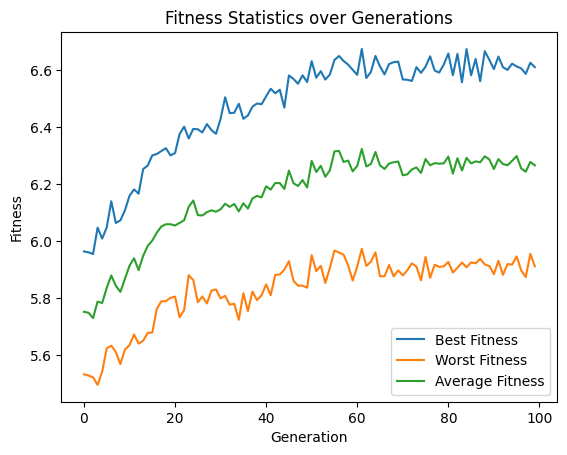

In [20]:
plot_fitness_statistics(num_generations, island_model.best_fitness, island_model.worst_fitness, island_model.avg_fitness)

In [ ]:
!jupyter nbconvert --to html ga_notebook.ipynb

### Save the run to disk

In [21]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
with open(os.path.join("saved_runs", f"island_model_aesthetics_works{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"), "wb") as f:
    pickle.dump(island_model, f) 

### Load the run from disk 
Notebook and library versions should match with the saved run

In [ ]:
import pickle
import os

with open(os.path.join("saved_runs", "insert_filename"), "rb") as f:
    island_model = pickle.load(f)

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary_imaging.processing as ip
from PIL import Image

num_generations = 22  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join(ip.RESULTS_FOLDER, f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.fitness_filename_sorting_key, reverse=True)
print(image_files[0])
Image.open(image_files[0])

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary_imaging.processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) 